
经过了`Transformer学习.ipynb`后，我把那里面的代码整理到了`transformer/model.py` 和`transformer/train.py`。

这样这个notebook会看起来比较简洁。主要用来绘图。

然后下面的代码主要是`train.py`的主函数部分

In [2]:
%load_ext autoreload
%autoreload 2
import os
os.chdir(os.path.dirname(os.path.dirname(os.getcwd())))  # 把工作路径转到主目录下

In [3]:
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
tf.__version__

'2.0.0'

In [4]:
from transformer.model import TransformerClassifier
from transformer.train import CustomSchedule

# 训练

## 构建数据集

In [4]:
from utils.preprocess import load_testcnn_data, load_tokenizer_binarizer

# testcnn和transformer预处理的数据是一致的
train_x, dev_x, test_x, train_y, dev_y, test_y = load_testcnn_data()
tokenizer, mlb = load_tokenizer_binarizer()
BUFFER_SIZE = 256
BATCH_SIZE = 128

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))

# 将数据集缓存到内存中以加快读取速度。
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE,reshuffle_each_iteration=True).batch(BATCH_SIZE, drop_remainder=False)

# 流水线技术 重叠训练的预处理和模型训练步骤。当加速器正在执行训练步骤 N 时，CPU 开始准备步骤 N + 1 的数据。这样做可以将步骤时间减少到模型训练与抽取转换数据二者所需的最大时间（而不是二者时间总和）。
# 没有流水线技术，CPU 和 GPU/TPU 大部分时间将处于闲置状态:
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

## 设定超参并建模

In [6]:
num_layers = 4
d_model = 128
num_heads = 8
dff = 512
vocab_size = 50000
maximum_position_encoding=10000
output_dim = len(train_y[0])  # 97
dropout_rate = 0.1
# max_seq_len = 128

steps_per_epoch = len(train_x) // BATCH_SIZE + 1
epochs = 10

In [7]:
model = TransformerClassifier(num_layers, d_model, num_heads, dff, vocab_size, 
                                    maximum_position_encoding, output_dim, dropout_rate)

## 学习率

In [8]:
learning_rate = CustomSchedule(d_model)
# 配置优化器
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

## 评估指标和损失函数

In [9]:
from utils.metrics import micro_f1, macro_f1
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction='auto')

## checkpoint

In [10]:
checkpoint_path = "notebook/Transformer/checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=model,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=1)

# 如果检查点存在，则恢复最新的检查点。
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

## **Training**

In [11]:
from transformer.train import predict, evaluation, create_padding_mask

之前的训练代码是这样的，但是我为了更好的分析结果。需要把这个代码改动一下

In [12]:
def training():
    # 该 @tf.function 将追踪-编译 train_step 到 TF 图中，以便更快地
    # 执行。该函数专用于参数张量的精确形状。为了避免由于可变序列长度或可变
    # 批次大小（最后一批次较小）导致的再追踪，使用 input_signature 指定
    # 更多的通用形状。
    # 这里填的128指的是句子的长度
    train_step_signature = [
        tf.TensorSpec(shape=(None, 128), dtype=tf.float32),
        tf.TensorSpec(shape=(None, None), dtype=tf.float32),
    ]

    @tf.function(input_signature=train_step_signature)
    def train_step(x, y):

        enc_padding_mask = create_padding_mask(x)
        with tf.GradientTape() as tape:
            y_pred = model(x, training=True, enc_padding_mask=enc_padding_mask)
            loss = loss_object(y, y_pred)

        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        train_loss(loss)
        train_accuracy(y, y_pred)

        mi_f1=micro_f1(y, y_pred)
        ma_f1=macro_f1(y, y_pred)
        return mi_f1, ma_f1, y_pred


    # 训练
    for epoch in range(epochs):
        start = time.time()

        train_loss.reset_states()
        train_accuracy.reset_states()

        for batch, (x, y) in enumerate(train_dataset.take(steps_per_epoch)):
            mi_f1 ,ma_f1, _ = train_step(x, y)

            if batch % 20 == 0:
                print('epoch {} batch {:3d} loss {:.4f} acc {:.4f} micro_f1 {:.4f} macro_f1 {:.4f}'.format(
                    epoch+1, batch+1, train_loss.result(), 
                    train_accuracy.result(), mi_f1, ma_f1))
            break
        # 每隔5轮保存一下        
        if (epoch + 1) % 5 == 0:
            ckpt_save_path = ckpt_manager.save()
            print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                             ckpt_save_path))

        print('Epoch {} Loss {:.4f}'.format(epoch + 1, train_loss.result()))
        evaluation(dev_x, dev_y)
        print('Time taken for 1 epoch {:.2f} sec\n'.format(time.time() - start))

## 训练

In [13]:
train_step_signature = [
    tf.TensorSpec(shape=(None, 128), dtype=tf.float32),
    tf.TensorSpec(shape=(None, None), dtype=tf.float32),
]

@tf.function(input_signature=train_step_signature)
def train_step(x, y):

    enc_padding_mask = create_padding_mask(x)
    with tf.GradientTape() as tape:
        y_pred = model(x, training=True, enc_padding_mask=enc_padding_mask)
        loss = loss_object(y, y_pred)

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    train_loss(loss)
    train_accuracy(y, y_pred)

    mi_f1=micro_f1(y, y_pred)
    ma_f1=macro_f1(y, y_pred)
    return mi_f1, ma_f1, y_pred

loss_record = []
# 为了之后绘制曲线
dev_micro = []
dev_macro = []

train_micro = []
train_macro = []

for epoch in range(epochs):
    start = time.time()
    
    train_loss.reset_states()
    train_accuracy.reset_states()
    
    train_y_true = []
    train_y_pred = []
    
    
    for batch, (x, y) in enumerate(train_dataset.take(steps_per_epoch)):
        mi_f1 ,ma_f1, y_pred = train_step(x, y)
        train_y_pred.append(y_pred)
        train_y_true.append(y)
        if batch % 50 == 0:
            print('epoch {} batch {:3d} loss {:.4f} acc {:.4f} micro_f1 {:.4f} macro_f1 {:.4f}'.format(
                epoch+1, batch+1, train_loss.result(), 
                train_accuracy.result(), mi_f1, ma_f1))
            
    loss_record.append(train_loss.result())  # 记录下每轮loss的变化
    print('Epoch {} Loss {:.4f}'.format(epoch + 1, train_loss.result()))
    
    _, mi, ma = evaluation(model, dev_x, dev_y)
    
    train_y_true = tf.concat(train_y_true, axis=0)
    train_y_pred = tf.concat(train_y_pred, axis=0)
    
    dev_micro.append(mi.numpy())
    dev_macro.append(ma.numpy())
    train_micro.append(micro_f1(train_y_true, train_y_pred).numpy())
    train_macro.append(macro_f1(train_y_true, train_y_pred).numpy())
    
    print('Time taken for 1 epoch {:.2f} sec\n'.format(time.time() - start))

epoch 1 batch   1 loss 0.9101 acc 0.6293 micro_f1 0.0658 macro_f1 0.0384
epoch 1 batch  51 loss 0.4925 acc 0.8322 micro_f1 0.0908 macro_f1 0.0058
epoch 1 batch 101 loss 0.3255 acc 0.8943 micro_f1 0.1280 macro_f1 0.0087
Epoch 1 Loss 0.2672
val accuracy 0.9598, micro f1 0.1490 macro f1 0.0110
Time taken for 1 epoch 44.37 sec

epoch 2 batch   1 loss 0.1393 acc 0.9583 micro_f1 0.1752 macro_f1 0.0137
epoch 2 batch  51 loss 0.1225 acc 0.9639 micro_f1 0.4554 macro_f1 0.0900
epoch 2 batch 101 loss 0.1074 acc 0.9671 micro_f1 0.5917 macro_f1 0.1823
Epoch 2 Loss 0.0957
val accuracy 0.9790, micro f1 0.7213 macro f1 0.4012
Time taken for 1 epoch 38.95 sec

epoch 3 batch   1 loss 0.0586 acc 0.9793 micro_f1 0.7269 macro_f1 0.3585
epoch 3 batch  51 loss 0.0579 acc 0.9799 micro_f1 0.7742 macro_f1 0.3778
epoch 3 batch 101 loss 0.0529 acc 0.9812 micro_f1 0.7873 macro_f1 0.4439
Epoch 3 Loss 0.0487
val accuracy 0.9849, micro f1 0.8198 macro f1 0.6576
Time taken for 1 epoch 38.52 sec

epoch 4 batch   1 loss

# 绘图

In [14]:
import pandas as pd

In [ ]:
# history = pd.read_csv('notebook/Transformer/transformer_report.csv')

In [15]:
history = pd.DataFrame([loss_record, dev_micro, dev_macro, train_micro, train_macro],
                        index=['train_loss', 'dev_micro', 'dev_macro', 'train_micro', 'train_macro']).T

In [16]:
history

,train_loss,dev_micro,dev_macro,train_micro,train_macro
0,"tf.Tensor(0.26717302, shape=(), dtype=float32)",0.148993,0.0109528,0.0900414,0.0299966
1,"tf.Tensor(0.0957471, shape=(), dtype=float32)",0.721341,0.401237,0.508031,0.164998
2,"tf.Tensor(0.048721515, shape=(), dtype=float32)",0.819765,0.657625,0.769467,0.507599
3,"tf.Tensor(0.03310945, shape=(), dtype=float32)",0.848892,0.722457,0.84796,0.692398
4,"tf.Tensor(0.02511147, shape=(), dtype=float32)",0.869625,0.773193,0.88659,0.784156
5,"tf.Tensor(0.02086445, shape=(), dtype=float32)",0.878489,0.790805,0.909004,0.83619
6,"tf.Tensor(0.018162627, shape=(), dtype=float32)",0.880315,0.80748,0.920203,0.87139
7,"tf.Tensor(0.015694626, shape=(), dtype=float32)",0.895176,0.829844,0.931481,0.88738
8,"tf.Tensor(0.01433434, shape=(), dtype=float32)",0.876133,0.814999,0.938867,0.905893
9,"tf.Tensor(0.012812984, shape=(), dtype=float32)",0.879371,0.797264,0.944457,0.91491


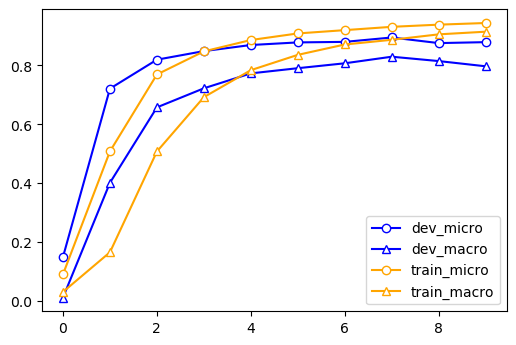

In [17]:
fig, ax = plt.subplots(dpi=100)
ax.plot(history.dev_micro, c='b', marker='o', mfc='w', label='dev_micro')
ax.plot(history.dev_macro, c='b', marker='^', mfc='w', label='dev_macro')
ax.plot(history.train_micro, c='orange', marker='o', mfc='w', label='train_micro')
ax.plot(history.train_macro, c='orange', marker='^', mfc='w', label='train_macro')
plt.legend()
plt.show()

In [24]:
history.to_csv('notebook/Transformer/transformer_report.csv', index=None)

# 预测

In [21]:
y_pred = predict(model, test_x)

In [22]:
mif1 = micro_f1(tf.cast(test_y, dtype=tf.float32), y_pred)
maf1 = macro_f1(tf.cast(test_y, dtype=tf.float32), y_pred)

In [23]:
print('test micro f1: {:.4f} macro f1: {:.4f}'.format(mif1.numpy(), maf1.numpy()))

test micro f1: 0.8751 macro f1: 0.7899
